In [1]:
import pandas as pd
import numpy as np
import sys
import math
import seaborn as sns
from matplotlib import pyplot as plt
import umap.umap_ as umap
import scipy.stats as stats
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, marker_expression_by_cell_type
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score

In [ ]:
# if save session
import dill
dill.dump_session('stellar_notebook_env.db')

In [ ]:
# restore session
import dill
dill.load_session('stellar_notebook_env.db')

## Process the dataset
- Use log2 for the channels (if needed)
- For each call/round of Tribus, perform always outlier truncation, set the maximum to the 99 or 95 percentile
- For each call/round of Tribus, perform always Z-score and then Min-Max transformation in all the channels

In [ ]:
# read input files
# STELLAR_data_donor_004_upperlevel_CL.csv, contains only colon region
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv", low_memory=False)
sample_data.columns.values

In [ ]:
sample_data = sample_data.fillna(0)
sample_data

In [ ]:
sample_data[['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']].describe()
# jump the log2 step...

In [ ]:
#  perform always outlier truncation, set the maximum to the 95 percentile
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']

Q = sample_data[cols].quantile(0.99)

sample_data_filtered = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
print(np.shape(sample_data_filtered))
sample_data_filtered[cols].describe()

In [ ]:
# For each call/round of Tribus 
# perform always Z-score and then Min-Max transformation in all the channels
# z-score
sample_data_scale = sample_data_filtered
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']
sample_data_scale.loc[:,(cols)] = sample_data_scale[cols].apply(stats.zscore, nan_policy='omit')
# define min max scaler
scaler = MinMaxScaler()
sample_data_scale.loc[:,(cols)] = scaler.fit_transform(sample_data_scale[cols])
sample_data_scale

In [ ]:
marker_expression(sample_data_scale[cols], markers=None, save=False, fname=None, dpi='figure', log=False)

label = {'Global': sample_data_scale['cell_type_upperlevel']}
label = pd.DataFrame(label)
marker_expression_by_cell_type(sample_data_scale[cols], label, cell_types=None, markers=None, level="Global", save=False, fname=None, dpi='figure', log=False)

In [ ]:
plt.figure(figsize=(12, 11))
sns.heatmap(sample_data_scale[cols].corr(),cmap=sns.cm.rocket_r)

# check the marker correlation matrix we choose for the clustering method
df = pd.ExcelFile(r"C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
marker_df = sample_data_scale[logic["Global"]["Epithelial"].index]
plt.figure(figsize=(10,8))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

In [ ]:
# save the processed dataset
sample_data_scale.to_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL_scaled.csv")

## Marker quality check (unprocessed dataset)

In [ ]:
# read input files
sample_data = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
sample_data = sample_data.drop(["...1", "x","y","tissue","cell_type_A","donor","unique_region","cell_type_upperlevel"], axis=1)

In [ ]:
# Plot marker histograms after filter with 99% percentiles
markers = sample_data.columns.values

fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 20))
fig.suptitle("Original Marker expression level", fontsize=30)
for i in range(len(markers)): 
    ax = axs[i//6, i%6]
    plt.sca(ax)
    hist, edges = np.histogram(sample_data[markers[i]][sample_data[markers[i]] < np.percentile(sample_data[markers[i]],99)], bins=50)
    plt.stairs(hist, edges, label="{}".format(markers[i]))
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()

In [ ]:
# Plot log transformed marker histograms after filter with 99% percentiles
sample_data_log = np.log(sample_data + abs(np.min(sample_data)) + sys.float_info.epsilon)
# sample_data_scaled = (sample_data_log - np.mean(sample_data_log)) / (np.std(sample_data_log))
# sample_data_norm = (sample_data_log - np.min(sample_data_log))/(np.max(sample_data_log) - np.min(sample_data_log))

fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 20))
fig.suptitle("Log-transformed Marker expression level filter with 99 percentile", fontsize=30)
for i in range(len(markers)-1): 
    ax = axs[i//6, i%6]
    plt.sca(ax)
    hist, edges = np.histogram(sample_data_log[markers[i]][sample_data_log[markers[i]] < np.percentile(sample_data_log[markers[i]],99)], 
                               bins=50)
    plt.stairs(hist, edges, label="{}".format(markers[i]))
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()

In [ ]:
# Plot marker expression histogram for each level 1 cell types
markers = sample_data.columns.values
sample_data_labeled = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel.csv',low_memory=False)
upper_celltype = np.unique(sample_data_labeled["cell_type_upperlevel"])
sample_data_log = np.log(sample_data + abs(np.min(sample_data)) + sys.float_info.epsilon)
sample_data_labeled_plot = sample_data_log.assign(cell_type_upperlevel=sample_data_labeled["cell_type_upperlevel"])

fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 20))
fig.suptitle("Log-transformed Marker expression level per cell type", fontsize=30)

for i in range(len(markers)): 
    ax = axs[i//6, i%6]
    plt.sca(ax)
    for uc in upper_celltype: 
        subset = sample_data_labeled_plot.loc[sample_data_labeled_plot["cell_type_upperlevel"]==uc]
        hist, edges = np.histogram(subset[markers[i]][subset[markers[i]] < np.percentile(subset[markers[i]],99)], bins=50)
        plt.stairs(hist, edges, label="{}".format(uc))
        plt.legend(loc='upper right')
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()


In [ ]:
marker_df = sample_data.drop(["x","y","tissue","cell_type_A","donor","unique_region","cell_type_upperlevel"], axis=1)
plt.figure(figsize=(12, 11))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

# Run Tribus for 1st level

## Analysis STELLAR dataset donor_004

In [ ]:
# read input files
sample_data = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
df = pd.ExcelFile(r"C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
sample_data = sample_data.drop(["...1"], axis=1)
sample_data

In [ ]:
# check the marker correlation matrix we choose for the clustering method
marker_df = sample_data[logic["Global"]["Epithelial"].index]
plt.figure(figsize=(10,8))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

In [ ]:
# Run Tribus on z-scored dataset
labels, scores = run_tribus(sample_data, logic, depth=1, normalization=z_score) # modify depth

In [ ]:
labels.head(10)

## Visualize the result and check the quality

In [ ]:
depth=1
if depth == 1: 
    label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
    name = label_stat['final_label']
    num = label_stat['count']
    fig, ax = plt.subplots(figsize =(6, 3))
    plt.title('Tribus result')
    ax.barh(name, num)

    label_stat = pd.DataFrame({'Group': sample_data['cell_type_upperlevel']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
    name = label_stat['Group']
    num = label_stat['count']
    fig, ax = plt.subplots(figsize =(6, 3))
    plt.title('Origin result')
    ax.barh(name, num)
else: 
    label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
    name = label_stat['final_label']
    num = label_stat['count']
    fig, ax = plt.subplots(figsize =(6, 3))
    plt.title('Tribus result')
    ax.barh(name, num)

    label_stat = pd.DataFrame({'Group': sample_data['cell_type_A']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
    name = label_stat['Group']
    num = label_stat['count']
    fig, ax = plt.subplots(figsize =(6, 3))
    plt.title('Origin result')
    ax.barh(name, num)

In [ ]:
# Marker Expression heatmap (use median value)

heatmap_for_median_expression(sample_data, labels, logic, level="Global", save=False, fname=None,
                                  dpi='figure', transform=z_score, title="Global Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

""" heatmap_for_median_expression(sample_data, labels, logic, level="Myeloid", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Myeloid Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

heatmap_for_median_expression(sample_data, labels, logic, level="Lymphoid", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Lymphoid Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

heatmap_for_median_expression(sample_data, labels, logic, level="Stromal", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Stromal Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1) """

In [ ]:
# confusion matrix
donor_004_upperlevel = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
celltype_true = np.array(donor_004_upperlevel["cell_type_upperlevel"]).tolist()
celltype_pred = np.array(labels["final_label"]).tolist()
cm_labels = np.unique(labels["final_label"])
cm = confusion_matrix(celltype_true, 
                      celltype_pred, 
                      labels = cm_labels)
                                                       
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')


cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (5,4))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
# scale the dataset into (0,1) before UMAP
#scaler = MinMaxScaler() 
#arr_scaled = scaler.fit_transform(sample_data)
#sample_data_scaled = pd.DataFrame(arr_scaled, columns=sample_data.columns,index=sample_data.index)

umap_vis(sample_data, labels, markers=logic["Global"].index.values.tolist(), save=False, fname=None,  level="Global", title=None, init='spectral',
             random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation', palette_markers='mycolormap',
             palette_cell='tab10', dpi='figure')

## Save the cell typing result if satisfied

In [ ]:
labels.to_csv(r"C:\Users\Public\Farkkila_lab_datasets\Tribus\Test_case_data\STELLAR\output_data\STELLAR_celltyping_v3.csv")

# Run Tribus for 2nd level

In [ ]:
# read input files
sample_data = pd.read_csv('C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
sample_data = sample_data.drop(["...1"], axis=1)
sample_data

# Run Tribus on z-scored dataset
labels, scores = run_tribus(sample_data, logic, depth=2, normalization=z_score) # modify depth # REQUIRED_CELLS_FOR_CLUSTERING = 10000

In [ ]:
labels.head(10)

In [ ]:
# Barplot, show the number of cells in each type
label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
name = label_stat['final_label']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 4))
plt.title('Tribus result')
ax.barh(name, num)

donor_004_upperlevel = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
label_stat = donor_004_upperlevel["cell_type_A"].value_counts().rename_axis('final_label').reset_index(name='count')
name = label_stat['final_label']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 4))
plt.title('Origin result')
ax.barh(name, num)

In [ ]:
# Marker Expression heatmap (use median value)

heatmap_for_median_expression(sample_data, labels, logic, level="Global", save=False, fname=None,
                                  dpi='figure', transform=z_score, title="Global Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

heatmap_for_median_expression(sample_data, labels, logic, level="Myeloid", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Myeloid Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

heatmap_for_median_expression(sample_data, labels, logic, level="Lymphoid", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Lymphoid Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

heatmap_for_median_expression(sample_data, labels, logic, level="Stromal", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Stromal Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

heatmap_for_median_expression(sample_data, labels, logic, level="Epithelial", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Epithelial Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

In [ ]:
# confusion matrix for final level
donor_004_upperlevel = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
celltype_true = np.array(donor_004_upperlevel["cell_type_A"]).tolist()
celltype_pred = np.array(labels["final_label"]).tolist()
cm_labels = np.unique(labels["final_label"])
cm = confusion_matrix(celltype_true, 
                      celltype_pred, 
                      labels = cm_labels)
                                                       
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')


cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
# confusion matrix for first level
donor_004_upperlevel = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
celltype_true = np.array(donor_004_upperlevel["cell_type_upperlevel"]).tolist()
celltype_pred = np.array(labels["Global"]).tolist()
cm_labels = np.unique(labels["Global"])
cm = confusion_matrix(celltype_true, 
                      celltype_pred, 
                      labels = cm_labels)
                                                       
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')


cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
# scale the dataset into (0,1) before UMAP
#scaler = MinMaxScaler() 
#arr_scaled = scaler.fit_transform(sample_data)
#sample_data_scaled = pd.DataFrame(arr_scaled, columns=sample_data.columns,index=sample_data.index)

umap_vis(sample_data, labels, markers=logic["Global"].index.values.tolist(), save=False, fname=None,  level="Global", title=None, init='spectral',
             random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation', palette_markers='mycolormap',
             palette_cell='tab10', dpi='figure')

# Run tribus on processed CL dataset

In [2]:
# read input files
sample_data = pd.read_csv('C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL_scaled.csv',low_memory=False)
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
sample_data = sample_data.drop(["...1"], axis=1)

In [ ]:
# check the marker correlation matrix we choose for the clustering method
marker_df = sample_data[logic["Global"]["Epithelial"].index]
plt.figure(figsize=(10,8))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

In [7]:
# Run Tribus on z-scored dataset
depth = 2
labels, scores = run_tribus(sample_data, logic, depth=depth, normalization=z_score) # modify depth

Global, subsetting done
Myeloid, subsetting done
less than min sample_size
Lymphoid, subsetting done
Stromal, subsetting done
Epithelial, subsetting done
2.3470215082168577 minutes


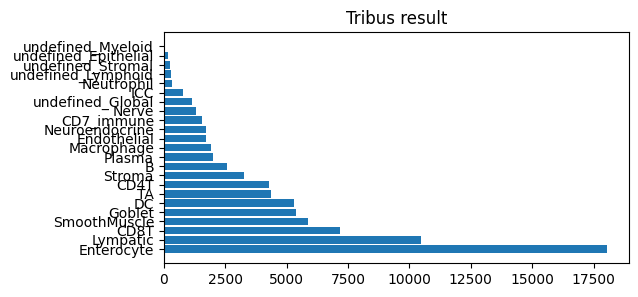

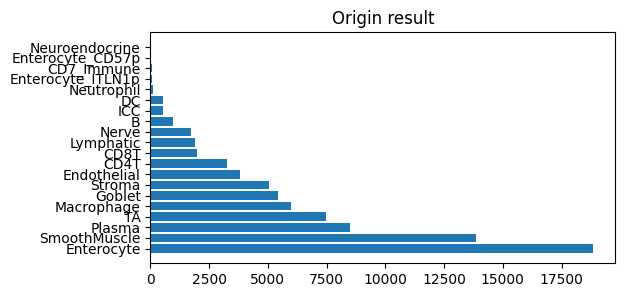

In [8]:
if depth == 1: 
    label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
    name = label_stat['final_label']
    num = label_stat['count']
    fig, ax = plt.subplots(figsize =(6, 3))
    plt.title('Tribus result')
    ax.barh(name, num)

    label_stat = pd.DataFrame({'Group': sample_data['cell_type_upperlevel']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
    name = label_stat['Group']
    num = label_stat['count']
    fig, ax = plt.subplots(figsize =(6, 3))
    plt.title('Origin result')
    ax.barh(name, num)
else: 
    label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
    name = label_stat['final_label']
    num = label_stat['count']
    fig, ax = plt.subplots(figsize =(6, 3))
    plt.title('Tribus result')
    ax.barh(name, num)

    label_stat = pd.DataFrame({'Group': sample_data['cell_type_A']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
    name = label_stat['Group']
    num = label_stat['count']
    fig, ax = plt.subplots(figsize =(6, 3))
    plt.title('Origin result')
    ax.barh(name, num)

<BarContainer object of 4 artists>

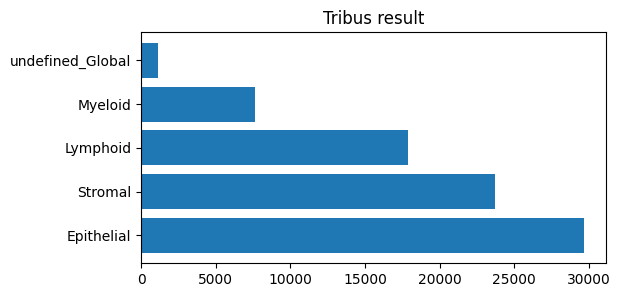

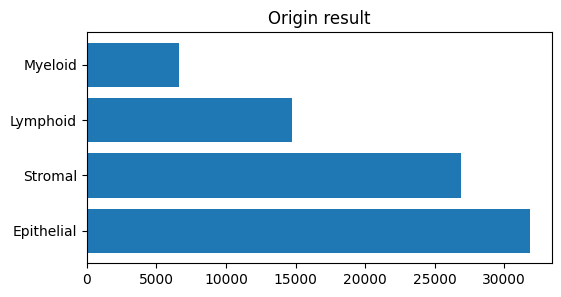

In [9]:
label_stat = labels["Global"].value_counts().rename_axis('final_label').reset_index(name='count')
name = label_stat['final_label']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Tribus result')
ax.barh(name, num)

label_stat = pd.DataFrame({'Group': sample_data['cell_type_upperlevel']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
name = label_stat['Group']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Origin result')
ax.barh(name, num)

             Epithelial  Lymphoid   Myeloid       Stromal
CD163          0.005162  0.013767  0.189479  5.678892e-03
HLADR          0.034869  0.041923  0.179101  3.813354e-02
CD16           0.019663  0.025301  0.104928  1.533629e-02
CD206          0.002530  0.005997  0.213830  2.096665e-03
BCL2           0.032910  0.139188  0.008814  1.208789e-02
CD69           0.013544  0.131414  0.034233  4.799769e-03
CD3            0.013534  0.057483  0.013694  1.156742e-02
CD127          0.071618  0.070848  0.044950  4.518146e-02
CD45           0.002665  0.223193  0.130437  5.161276e-04
CD38           0.000108  0.028958  0.008619  8.701766e-07
CD90           0.007440  0.053203  0.057029  9.267502e-02
Podoplanin     0.016807  0.032252  0.030075  3.118824e-02
CD34           0.026877  0.022900  0.018656  4.559298e-02
CD56           0.021897  0.015132  0.014204  2.992070e-02
CD49a          0.080301  0.036843  0.041867  2.289400e-01
aSMA           0.000111  0.000436  0.000167  3.029216e-02
CDX2          

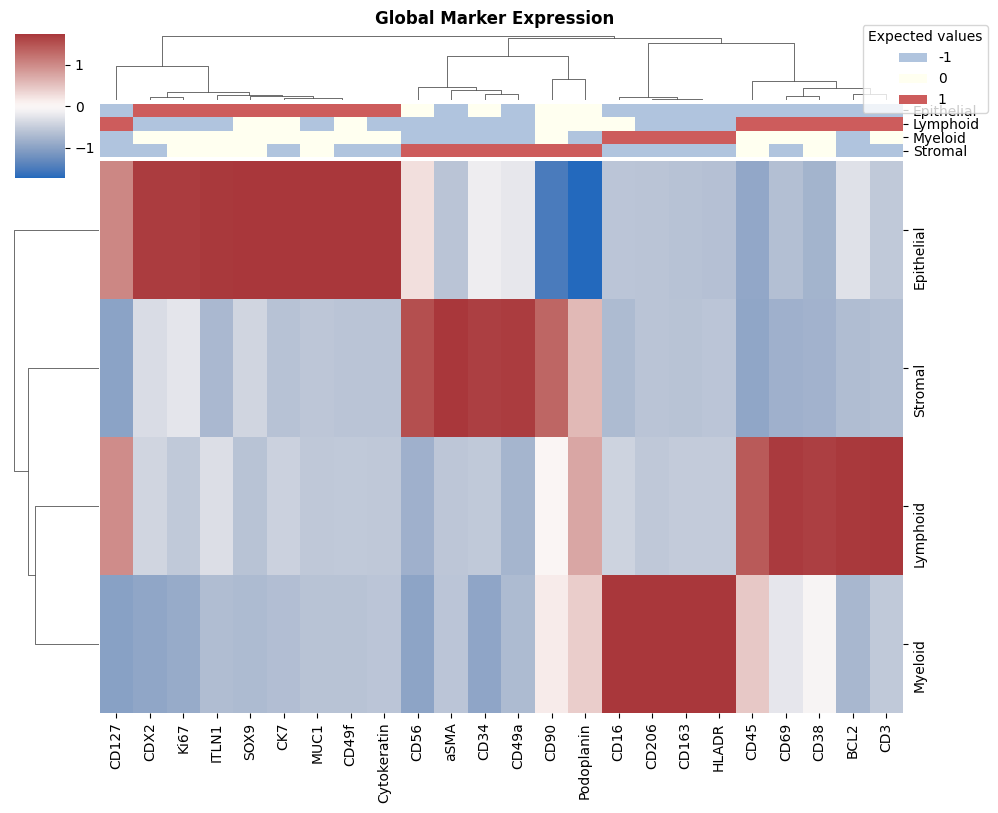

             DC  Macrophage  Neutrophil
CD11c  0.098521    0.023473    0.056628
CD206  0.161398    0.501553    0.114638
CD163  0.146101    0.406037    0.087874
CD15   0.000431    0.000003    0.235920
CD66   0.004796    0.001502    0.052195


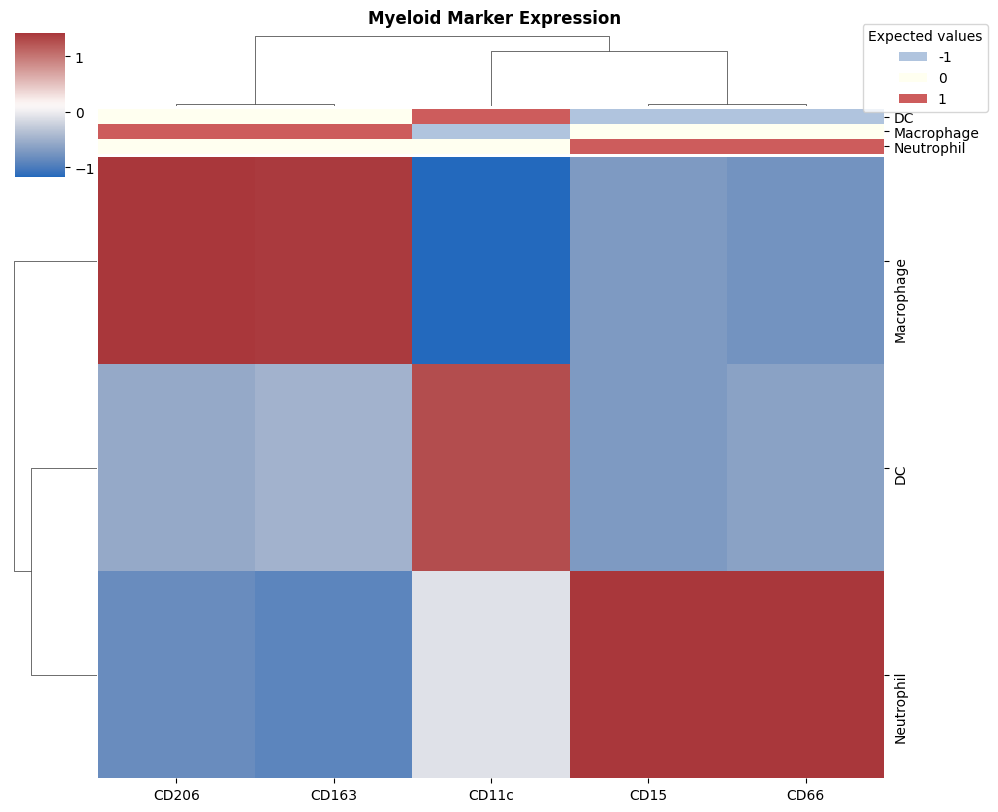

              B      CD4T  CD7_immune      CD8T    Plasma
CD21   0.349429  0.108725    0.056238  0.048295  0.143172
CD4    0.090770  0.188264    0.051711  0.020651  0.028212
CD8    0.028346  0.010264    0.051582  0.014064  0.010292
CD7    0.054279  0.050686    0.448286  0.023218  0.034518
CD38   0.026421  0.183182    0.006836  0.001145  0.525940
CD138  0.016002  0.034045    0.009653  0.019147  0.500486


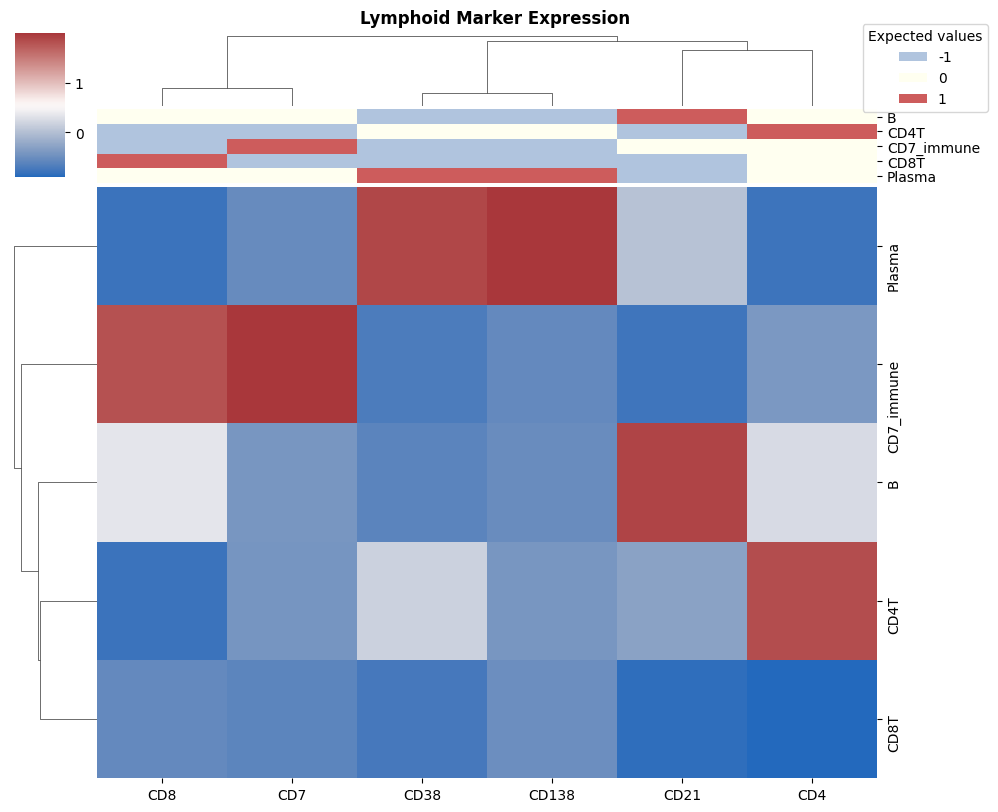

            Endothelial       ICC  Lympatic     Nerve  SmoothMuscle   
Vimentin       0.049746  0.019173  0.010114  0.057325      0.012029  \
Podoplanin     0.019430  0.044648  0.030748  0.301968      0.022050   
aSMA           0.008044  0.002386  0.013356  0.000113      0.371061   
CD56           0.061095  0.026396  0.026955  0.630318      0.027032   
CD117          0.014009  0.296325  0.010011  0.005871      0.006328   
CD36           0.364952  0.007309  0.005572  0.004773      0.004028   

                  Stroma  
Vimentin    3.490415e-01  
Podoplanin  4.474823e-02  
aSMA        6.642062e-07  
CD56        1.191620e-02  
CD117       6.218674e-03  
CD36        4.856474e-03  


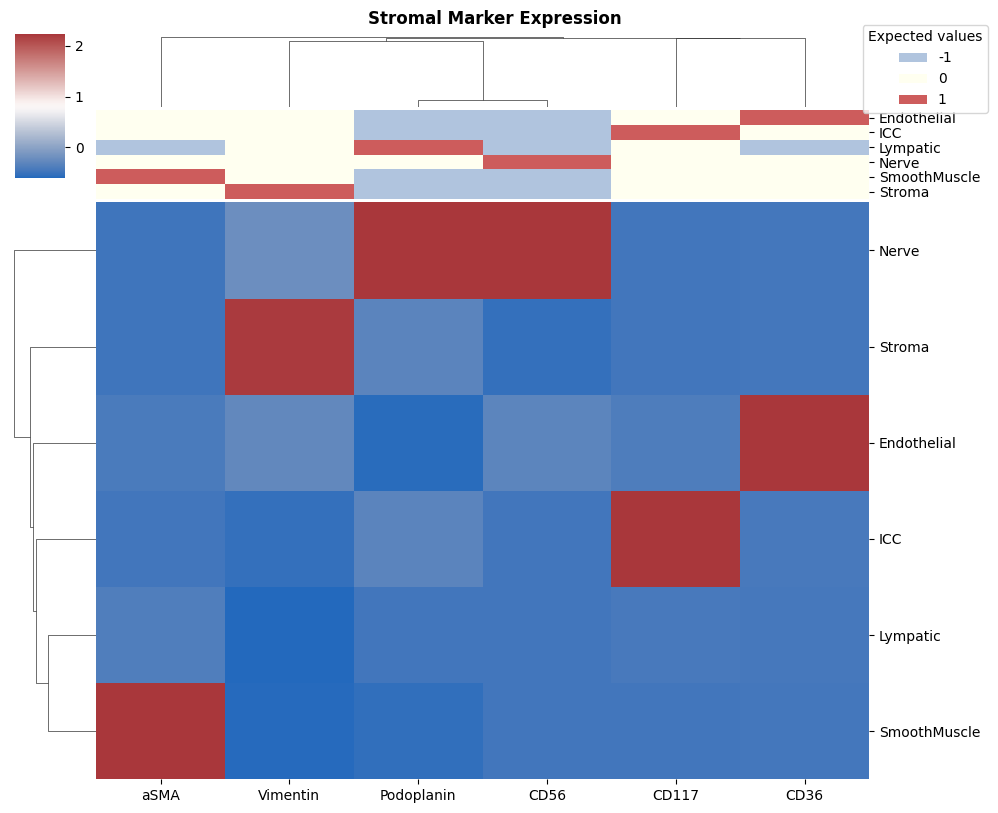

       Enterocyte    Goblet  Neuroendocrine        TA
CHGA     0.055270  0.061234        0.428142  0.053278
Ki67     0.048090  0.070279        0.095666  0.253663
MUC2     0.000404  0.344426        0.002018  0.037019
CD49f    0.314404  0.133498        0.171569  0.047920


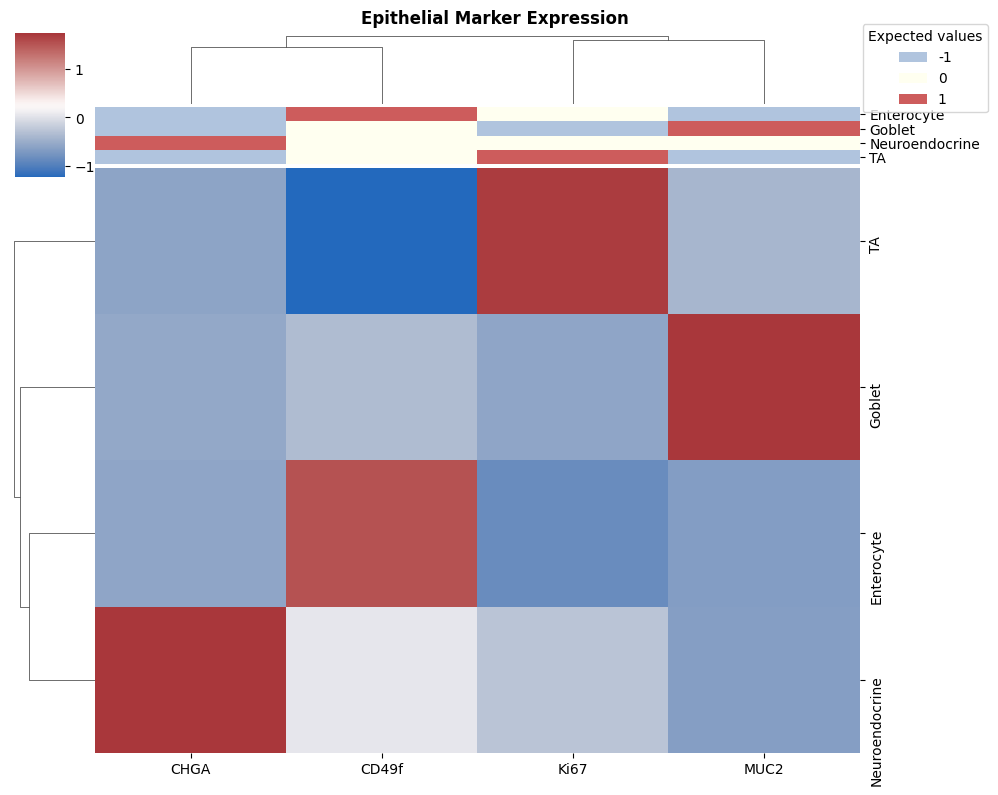

In [10]:
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=False, fname=None,
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_7928\2639141574.py:46: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.8646691339071256, Accuracy score = 0.4503541226875851, Precision score = 0.70695870244138, F1 score = 0.5051235849726112


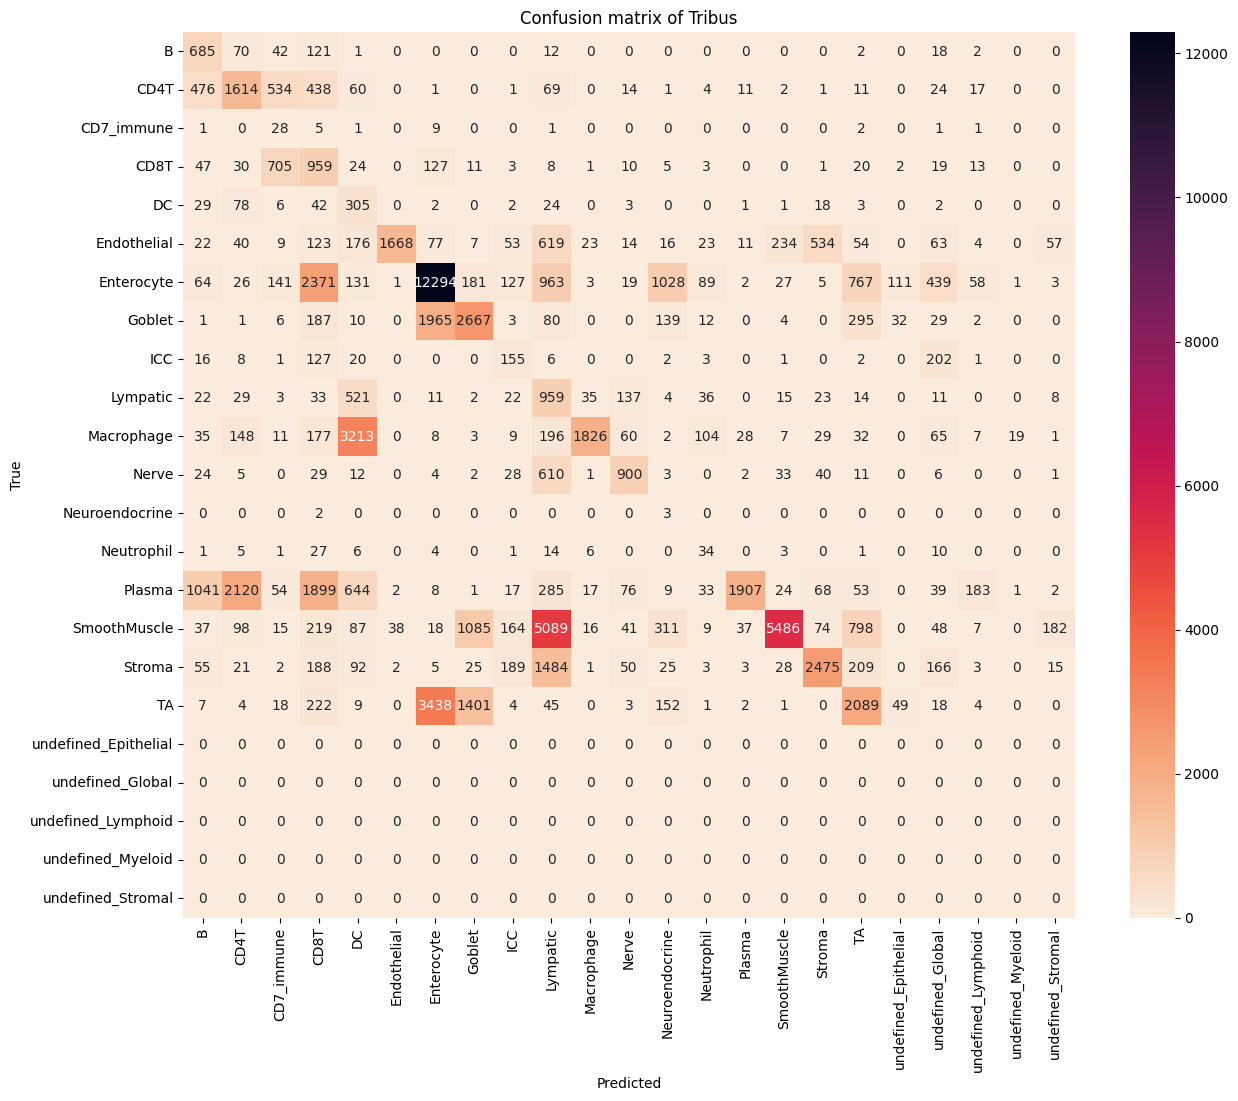

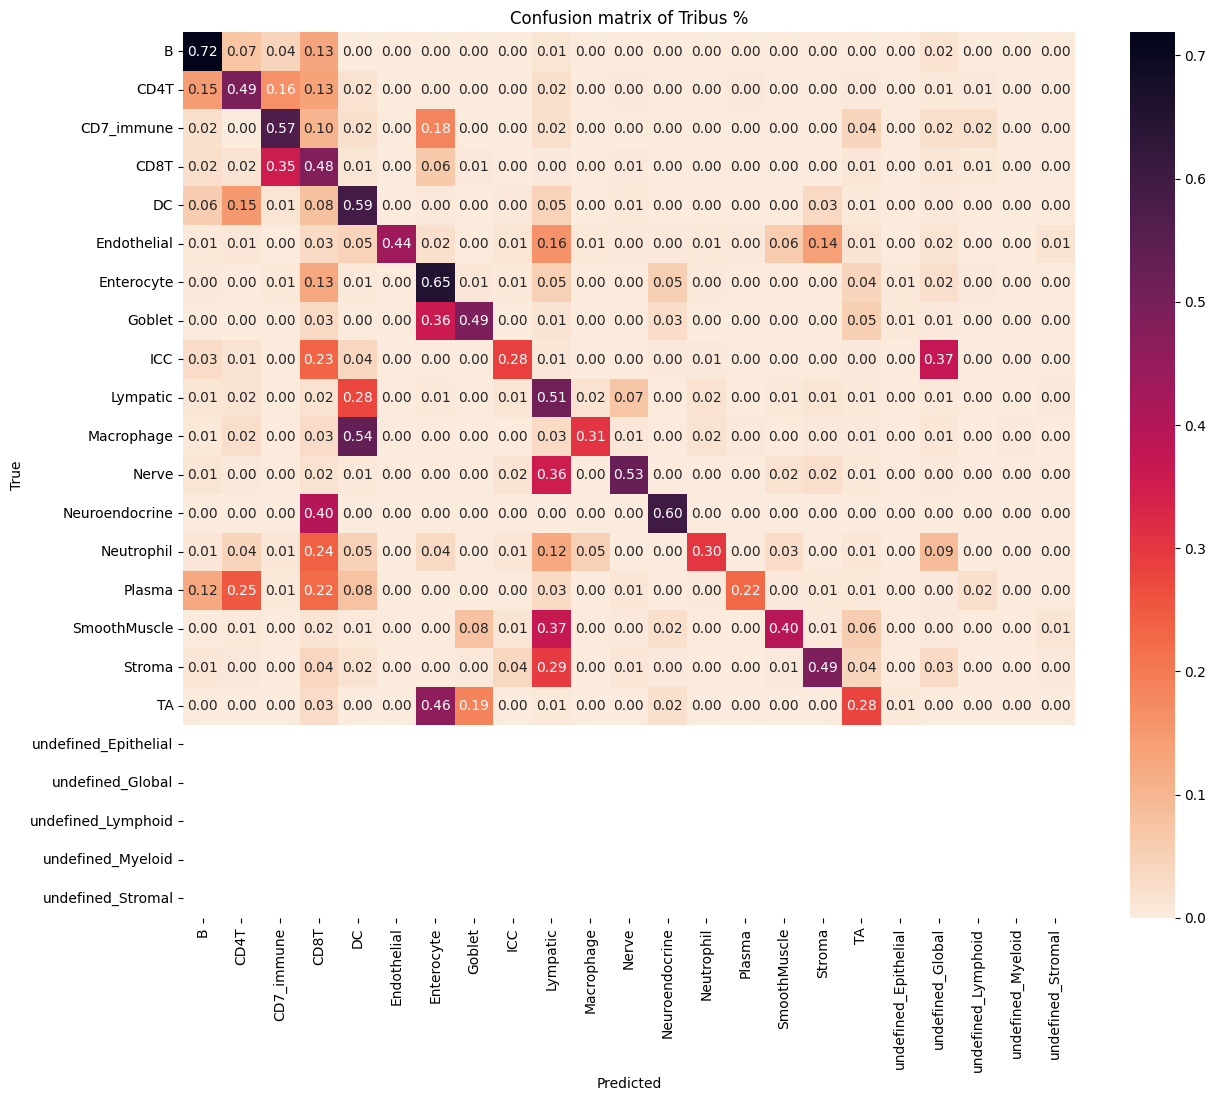

In [11]:
# confusion matrix
if depth == 1: 
    celltype_true = np.array(sample_data["cell_type_upperlevel"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
    cm_labels = np.unique(labels["final_label"])
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
else:
    celltype_true = np.array(sample_data["cell_type_A"]).tolist()
    celltype_true = [element.replace('Lymphatic', 'Lympatic') for element in celltype_true]
    celltype_true = [element.replace('CD7_Immune', 'CD7_immune') for element in celltype_true]
    celltype_pred = np.array(labels["final_label"]).tolist()
    cm_labels = np.unique(labels["final_label"])
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')

RI = rand_score(celltype_true, celltype_pred) #between 0-1
AS = accuracy_score(celltype_true, celltype_pred)
PS = precision_score(celltype_true, celltype_pred, average='weighted')
F1 = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_7928\3416899189.py:18: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Rand score = 0.8391483263388186, Accuracy score = 0.8321945613750203, Precision score = 0.8545788328914503, F1 score = 0.8401161867782257


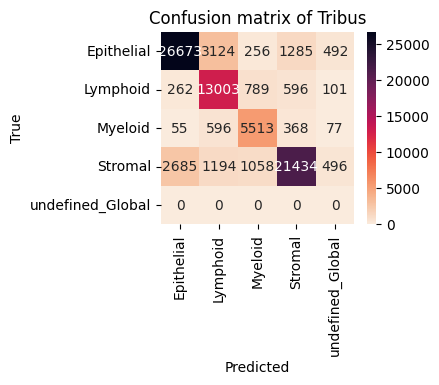

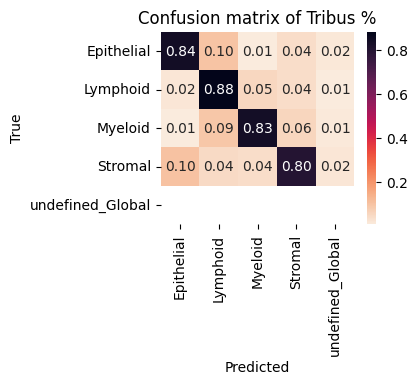

In [12]:
# confusion matrix for first level
celltype_true = np.array(sample_data["cell_type_upperlevel"]).tolist()
celltype_pred = np.array(labels["Global"]).tolist()
cm_labels = np.unique(labels["Global"])
cm = confusion_matrix(celltype_true, 
                      celltype_pred, 
                      labels = cm_labels)
                                                       
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')


cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

RI = rand_score(celltype_true, celltype_pred) #between 0-1
AS = accuracy_score(celltype_true, celltype_pred)
PS = precision_score(celltype_true, celltype_pred, average='weighted')
F1 = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))

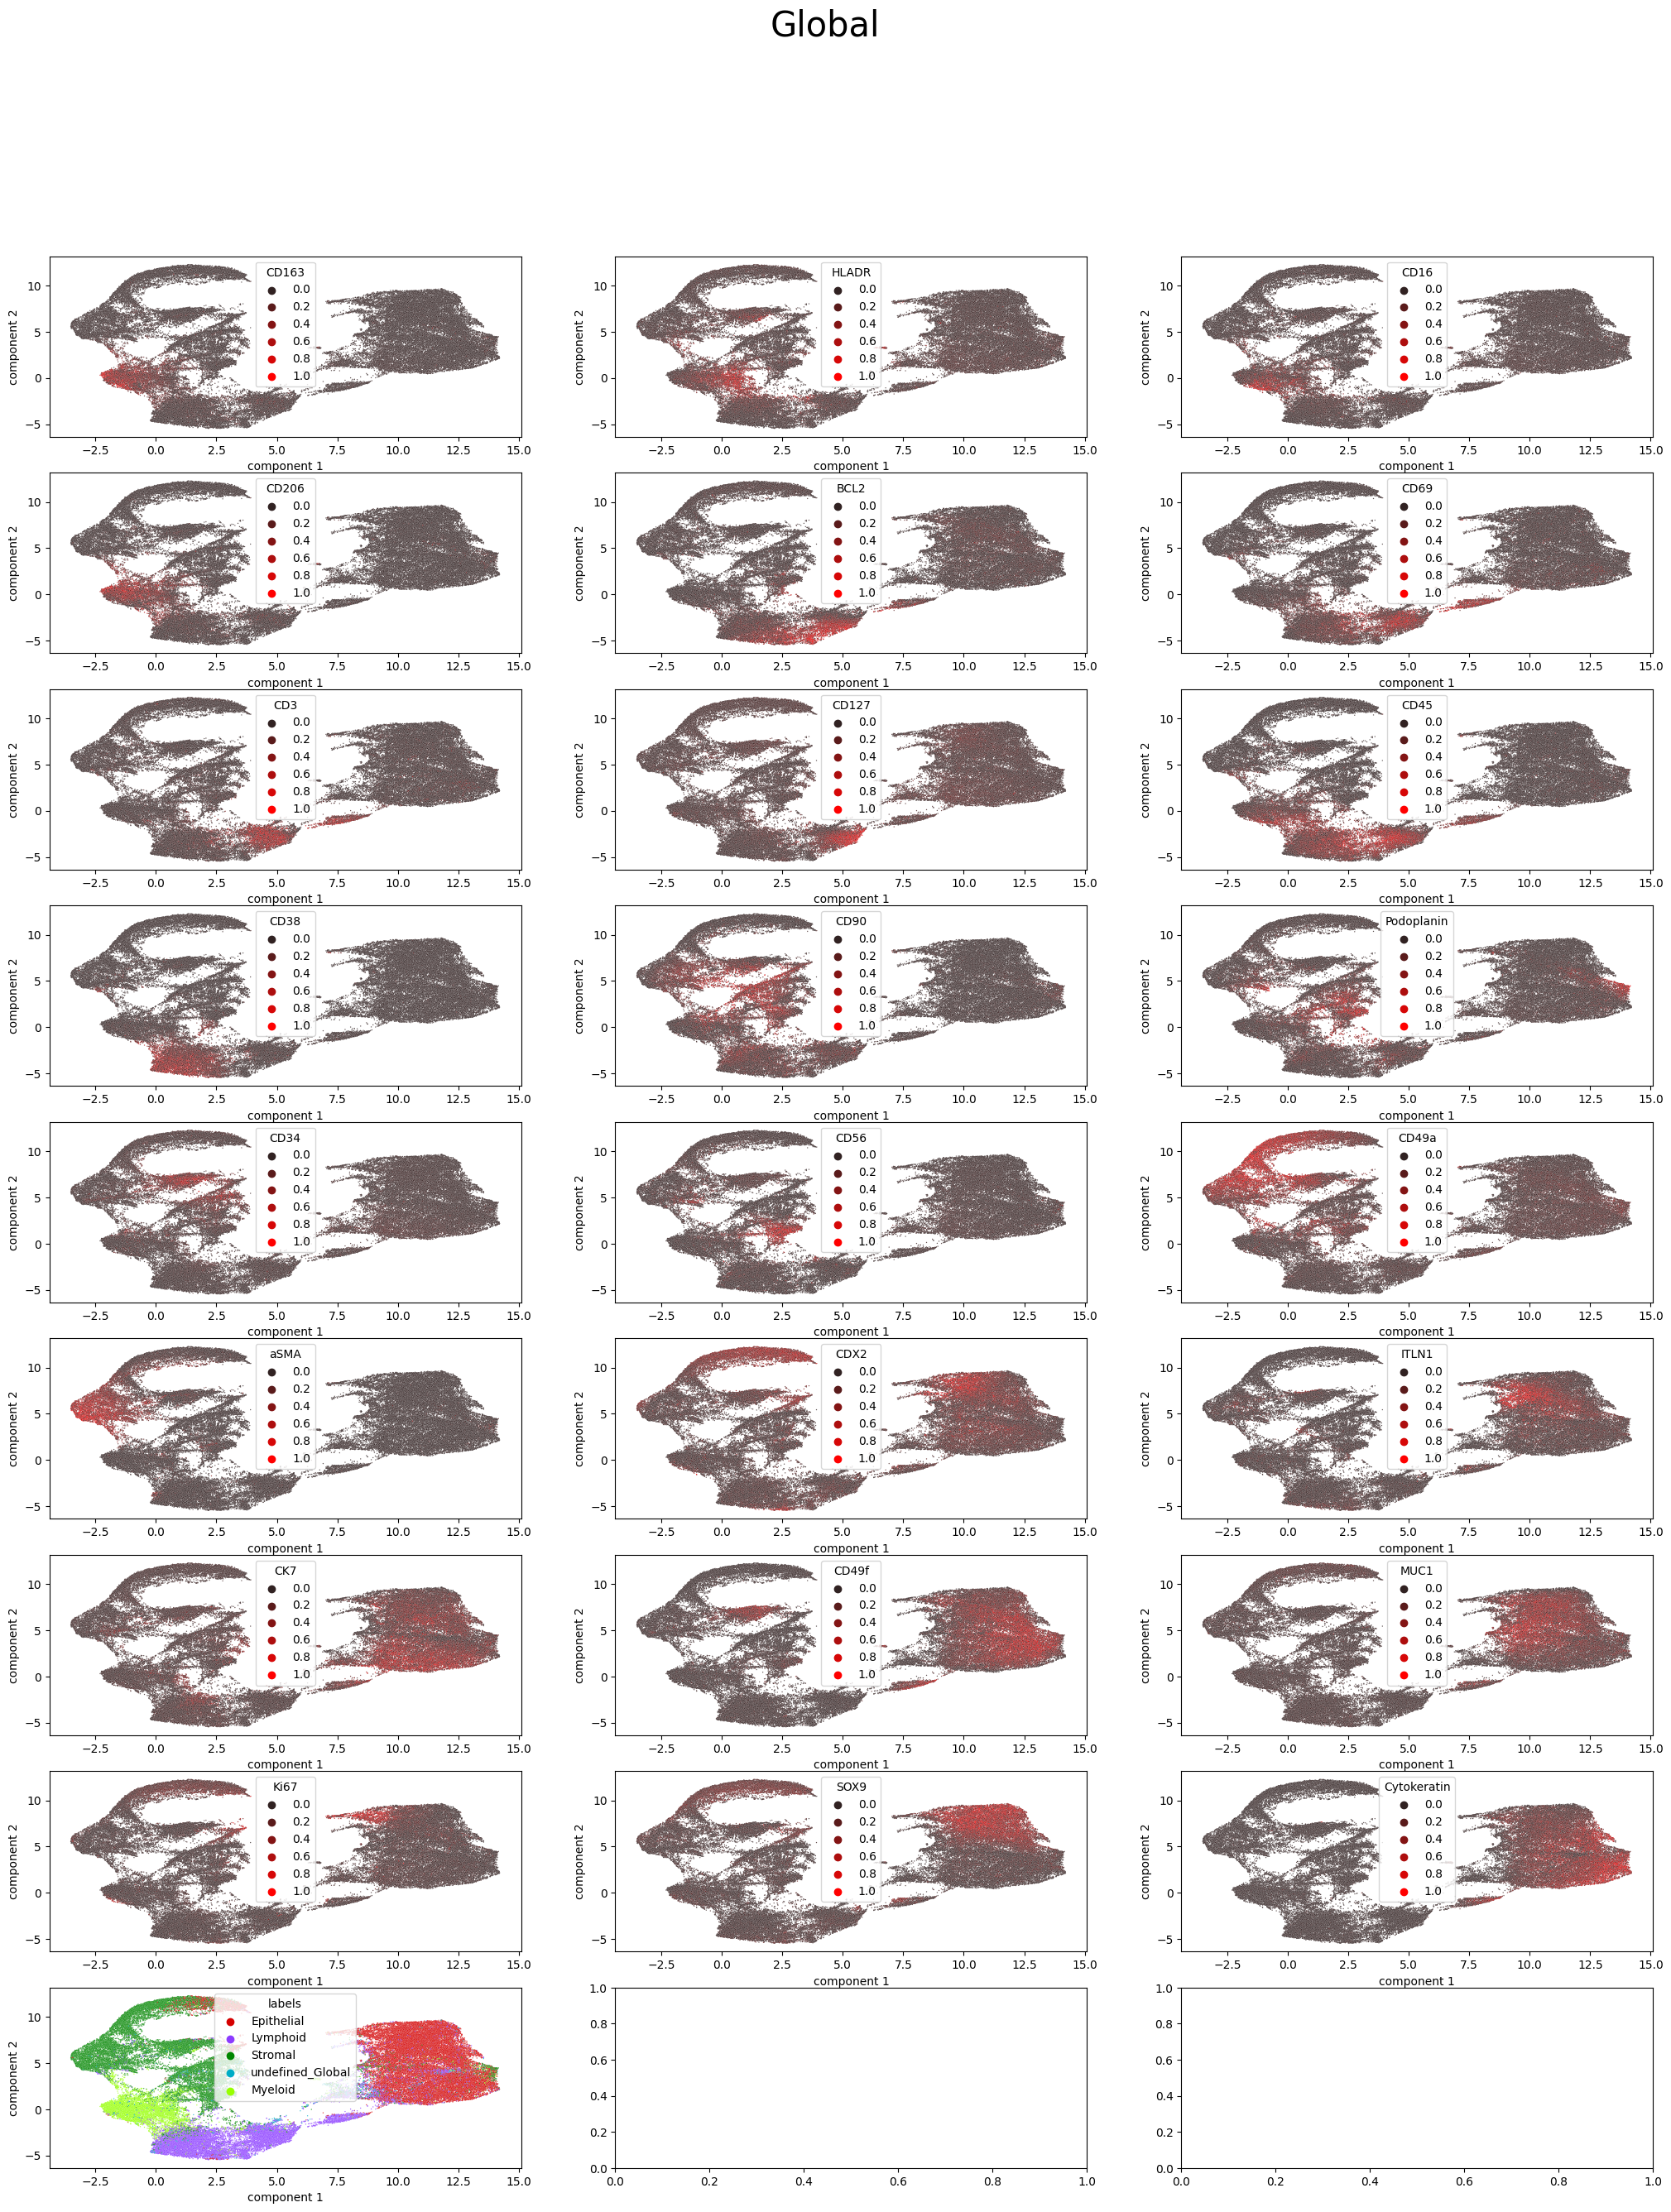

In [13]:
umap_vis(sample_data, labels, markers=logic["Global"].index.values.tolist(), save=False, fname=None,  level="Global", title=None, init='spectral',
             random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation', palette_markers='mycolormap',
             palette_cell='tab10', dpi='figure')

In [10]:
labels.to_csv(r"C:\Users\Public\Farkkila_lab_datasets\Tribus\Test_case_data\STELLAR\output_data\STELLAR_celltyping_cl_filtered_v2.csv")